# Wildfire Image Classification Project ML Pipeline 

In [27]:
import os
import torch
from glob import glob
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import imagehash
import matplotlib.pyplot as plt
from PIL import Image, ImageFile
from typing import List, Tuple, Set
from matplotlib.ticker import MaxNLocator
import numpy as np
from numpy import ndarray
from sklearn.neighbors import BallTree
from collections import Counter
from functools import partial

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device.type

'cuda'

In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Helper Functions

##### Obtaining (Near) Duplicate Images
Perceptual hashing (pHash) is used to represent the visual content of images in a compact and consistent manner by converting an image into a hash value that uniquely represents its visual characteristics. The hamming distance measure between the binary of the hashes is used to determine the similarity between images. The process of pHash is explained [here](https://hackerfactor.com/blog/index.php%3F/archives/432-Looks-Like-It.html).

In [6]:
def getBinaryArrayAsString(arr: ndarray):
  return ''.join('1' if x else '0' for x in arr.hash.flatten())

In [7]:
def removeSimilarImages(image_paths: Set[str], threshold: float) -> Tuple[int, List[Tuple[str, str]], Set[str]]:
  '''
  Removes (Near) duplicate images using Fast-implementation of kNN using BallTree.
  
  Returns:
  - Number of images with exact hash
  - A list pairs of near duplicate images where the second path is the removed path
  - A list of image paths that is free from any near duplicate images to the specified threshold
  '''
  
  def process_similar_items(removed_path: Set[str], distances: ndarray, indices: ndarray, curr_path: str) -> bool:
    for i in range(0, len(distances)):
      similarHashKey = ''.join(data[indices[i]].flatten())
      similarity = 1 - distances[i]
      
      if similarity >= threshold:
        similarPath = hash_image_dict[similarHashKey]
        near_duplicates.append((curr_path, similarPath))
        removed_path.add(similarPath)
      else:
        return False
    return True
        
  hash_image_dict = {getBinaryArrayAsString(imagehash.dhash(Image.open(path))): path for path in image_paths}
  num_exact_images = len(image_paths) - len(hash_image_dict)
  near_duplicates = [] 
  removed_path = set()
  
  data = np.array([list(value) for value in list(hash_image_dict.keys())])
  ballt = BallTree(data, metric='hamming')

  for hash, path in hash_image_dict.items():
    if (path in removed_path):
      continue
    
    k = 1   
    need_to_increase_k = True
    while need_to_increase_k:
      distances, indices = ballt.query([list(hash)], k=(k + 5), return_distance=True, sort_results=True)
      distances = distances.flatten()[k:]
      indices = indices.flatten()[k:]
      need_to_increase_k = process_similar_items(removed_path, distances, indices, path)
      k += 5

  remaining_paths = set(image_paths) - removed_path
  return (num_exact_images, near_duplicates, remaining_paths)  

##### Plotting Helper Functions

In [8]:
def plotImagePairs(image_paths: List[Tuple[str, str]], title: str) -> None:
  assert len(image_paths) > 0, 'image_paths must contain at least one pair'
  
  fig, axs = plt.subplots(nrows=len(image_paths), ncols=2, figsize=(6, 3 * len(image_paths)))
  suptitle = fig.suptitle(title, fontsize=16)

  if (len(image_paths) == 1):
    axs[0].set_title(f'First Image')
    axs[1].set_title(f'Second Image')
    first_image = Image.open(image_paths[0][0]).resize([24, 24])
    second_image = Image.open(image_paths[0][1]).resize([24, 24])

    axs[0].imshow(first_image)
    axs[1].imshow(second_image)
    suptitle.set_y(1.02)
    plt.show()
    return
  
  axs[0,0].set_title(f'First Image')
  axs[0,1].set_title(f'Second Image')
  for i in range(len(image_paths)):
    first_image = Image.open(image_paths[i][0]).resize([24, 24])
    second_image = Image.open(image_paths[i][1]).resize([24, 24])

    axs[i,0].imshow(first_image)
    axs[i,1].imshow(second_image)

  first_subplot_position = axs[0, 0].get_position()
  first_subplot_y = first_subplot_position.y1
  suptitle.set_y(first_subplot_y + 0.2 / len(image_paths))
  plt.show()

In [69]:
def plotBarGraph(groups: List[str], values: List[int], title: str) -> None:
  assert len(groups) > 0, 'Groups must be at least 1'
  assert len(groups) == len(values), 'Groups and values must have the same length'
  
  fig, axs = plt.subplots()
  fig.suptitle(title, fontsize=16, y=0.97)
  axs.bar(groups, values, color='#003f5c')
  axs.yaxis.set_major_locator(MaxNLocator(integer=True))
  axs.set_ylim(bottom=0)
  plt.show()

In [70]:
def plot2StackedBarGraph(groups: List[str], first_values: List[int], second_values: List[int], legend: List[str], title: str) -> None:
  assert len(groups) > 0, 'Groups must be at least 1'
  assert len(groups) == len(first_values) == len(second_values), 'Groups and values must have the same length'
  assert len(legend) == 2, 'Legend should have a length of 2'
  
  fig, axs = plt.subplots()
  fig.suptitle(title, fontsize=16, y=0.97)
  axs.bar(groups, first_values, label=legend[0], color='#003f5c')
  axs.bar(groups, second_values, bottom = first_values, label=legend[1], color='#bc5090')
  axs.yaxis.set_major_locator(MaxNLocator(integer=True))
  axs.legend()
  axs.set_ylim(bottom=0)
  plt.show()

In [71]:
def plot3StackedBarGraph(groups: List[str], first_values: List[int], second_values: List[int], third_values: List[int], legend: List[str], title: str) -> None:
  assert len(groups) > 0, 'Groups must be at least 1'
  assert len(groups) == len(first_values) == len(second_values) == len(third_values), 'Groups and values must have the same length'
  assert len(legend) == 3, 'Legend should have a length of 3'
  
  fig, axs = plt.subplots()
  fig.suptitle(title, fontsize=16, y=0.97)
  axs.bar(groups, first_values, label=legend[0], color='#003f5c')
  axs.bar(groups, second_values, bottom = first_values, label=legend[1], color='#bc5090')
  axs.bar(groups, third_values, bottom = np.add(first_values, second_values), label=legend[2], color='#ffa600')
  axs.yaxis.set_major_locator(MaxNLocator(integer=True))
  axs.legend()
  axs.set_ylim(bottom=0)
  plt.show()

In [60]:
def plotPieChartGraph(title: str, sizes: List[int], labels: List[str], explode: List[int]) -> None:
  assert len(labels) > 0, 'Labels must be at least 1'
  assert len(labels) == len(sizes) == len(explode), 'Labels, sizes, and explode must have the same length'
  
  plt.pie(sizes, labels=labels, autopct='%1.0f%%', pctdistance=0.5, labeldistance=1.3, explode=explode, shadow=True, startangle=90)
  plt.suptitle(title, fontsize=16, y=0.95)
  plt.figure(facecolor='white')
  plt.show()

##### Image Helper Methods

In [12]:
def isImageValid(image_path: str) -> bool:
  try:
    _ = Image.open(image_path)
    return True
  except:
    return False

### Hyper-Parameters

In [13]:
SIMILARITY_THRESHOLD = 0.80
IMAGE_SIZE = 244
BATCH_SIZE = 64
TRAIN_PERC = 0.8

### Image Preprocessing

##### Image Augmentation
- Resize: To make sure all the images will have the same size
- RandomHorizontalFlip: Data augmentation
- ToTensor: Since we are using pytorch it expects a tensor not a numpy; it will convert the values from 0-255 to 0-1
- Normalize: Normalises the mean and standard deviation of the rgb values to 0.5 for each of the 3 channels

In [14]:
transformer=transforms.Compose([
  transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(), 
  transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

##### Data Loader

In [17]:
data_path = os.path.join('data')

wildfire_paths = os.path.join('data', 'wildfire')
nowildfire_paths = os.path.join('data', 'nowildfire')

In [21]:
wildfire_image_paths = glob(wildfire_paths + '/*.jpg')
valid_wildfire_image_paths = [path for path in wildfire_image_paths if isImageValid(path)]
nowildfire_image_paths = glob(nowildfire_paths + '/*.jpg')
valid_nowildfire_image_paths = [path for path in nowildfire_image_paths if isImageValid(path)]

In [24]:
(num_exact_images_wildfire, near_duplicates_wildfire, remaining_paths_wildfire) = removeSimilarImages(valid_wildfire_image_paths, SIMILARITY_THRESHOLD)

In [25]:
(num_exact_images_nowildfire, near_duplicates_nowildfire, remaining_paths_nowildfire) = removeSimilarImages(valid_nowildfire_image_paths, SIMILARITY_THRESHOLD)

In [28]:
def isValidFile(image_path: str, valid_paths: List[str]) -> bool:
  return image_path in valid_paths

valid_data_paths = remaining_paths_wildfire.union(remaining_paths_nowildfire)
isValidDataFile = partial(isValidFile, valid_paths=valid_data_paths)

In [30]:
dataset = ImageFolder(data_path, transform=transformer, is_valid_file=isValidDataFile)
train_size = int(TRAIN_PERC * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

##### Data Anaylsis

This section aims to visualise the distribution and characteristics of the loaded data, including data distribution, number of corrupted image files, comparison between unique and duplicate images, and identification of exact and near-duplicate images.

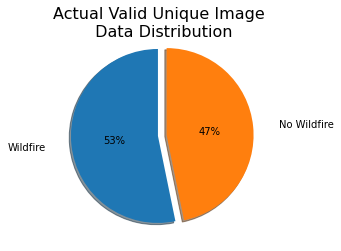

<Figure size 432x288 with 0 Axes>

In [95]:
classes = ['Wildfire', 'No Wildfire']
class_idx = dataset.class_to_idx
class_instance = dict(Counter(dataset.targets))

obtained_wildfire_count = class_instance[class_idx['wildfire']]
obtained_nowildfire_count = class_instance[class_idx['nowildfire']]

plotPieChartGraph(title='Actual Valid Unique Image \n Data Distribution', sizes=[obtained_wildfire_count, obtained_nowildfire_count], labels=classes, explode=[0.1, 0])

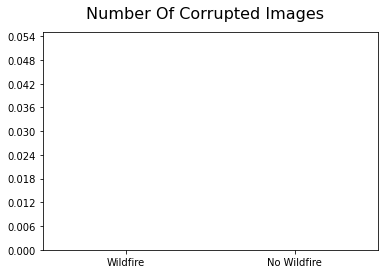

In [72]:
original_wildfire_count = len(wildfire_image_paths)
original_nowildfire_count = len(nowildfire_image_paths)

valid_wildfire_count = len(valid_wildfire_image_paths)
valid_nowildfire_count = len(valid_nowildfire_image_paths)

corrupted_wildfire_count = original_wildfire_count - valid_wildfire_count
corrupted_nowildfire_count = original_nowildfire_count - valid_nowildfire_count

plotBarGraph(groups=classes, values=[corrupted_wildfire_count, corrupted_nowildfire_count], title='Number Of Corrupted Images')

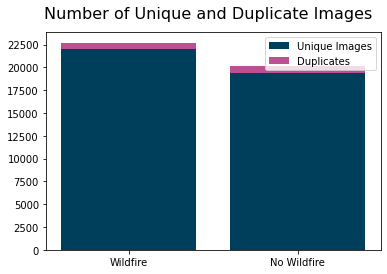

In [90]:
near_duplicates_wildfire_as_set = set([path[1] for path in near_duplicates_wildfire])
near_duplicates_nowildfire_as_set = set([path[1] for path in near_duplicates_nowildfire])

near_duplicates_wildfire_count = len(near_duplicates_wildfire_as_set)
near_duplicates_nowildfire_count = len(near_duplicates_nowildfire_as_set)

first_values = [obtained_wildfire_count, obtained_nowildfire_count]
second_values = [near_duplicates_wildfire_count + num_exact_images_wildfire, near_duplicates_nowildfire_count + num_exact_images_nowildfire]
legend = ['Unique Images', 'Duplicates']
plot2StackedBarGraph(classes, first_values, second_values, legend, 'Number of Unique and Duplicate Images')

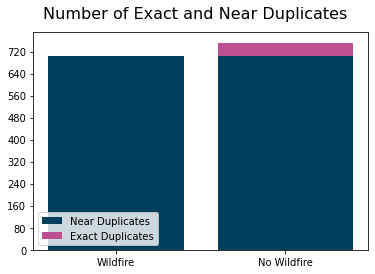

In [93]:
first_values = [near_duplicates_wildfire_count, near_duplicates_wildfire_count]
second_values = [num_exact_images_wildfire, num_exact_images_nowildfire]
legend = ['Near Duplicates', 'Exact Duplicates']
plot2StackedBarGraph(classes, first_values, second_values, legend, 'Number of Exact and Near Duplicates')